Epoch 0: Loss = 1.270206
Epoch 10: Loss = 1.208133
Epoch 20: Loss = 1.216642
Epoch 30: Loss = 1.221685
Epoch 40: Loss = 1.250782
Epoch 50: Loss = 1.258584
Epoch 60: Loss = 1.228755
Epoch 70: Loss = 1.218743
Epoch 80: Loss = 1.256820
Epoch 90: Loss = 1.217197


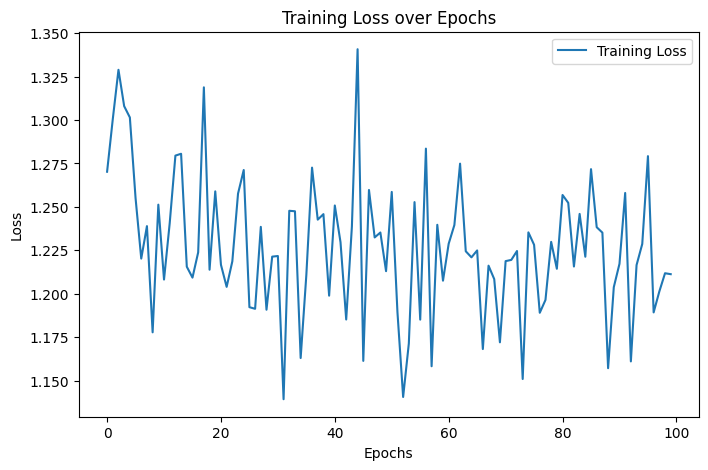

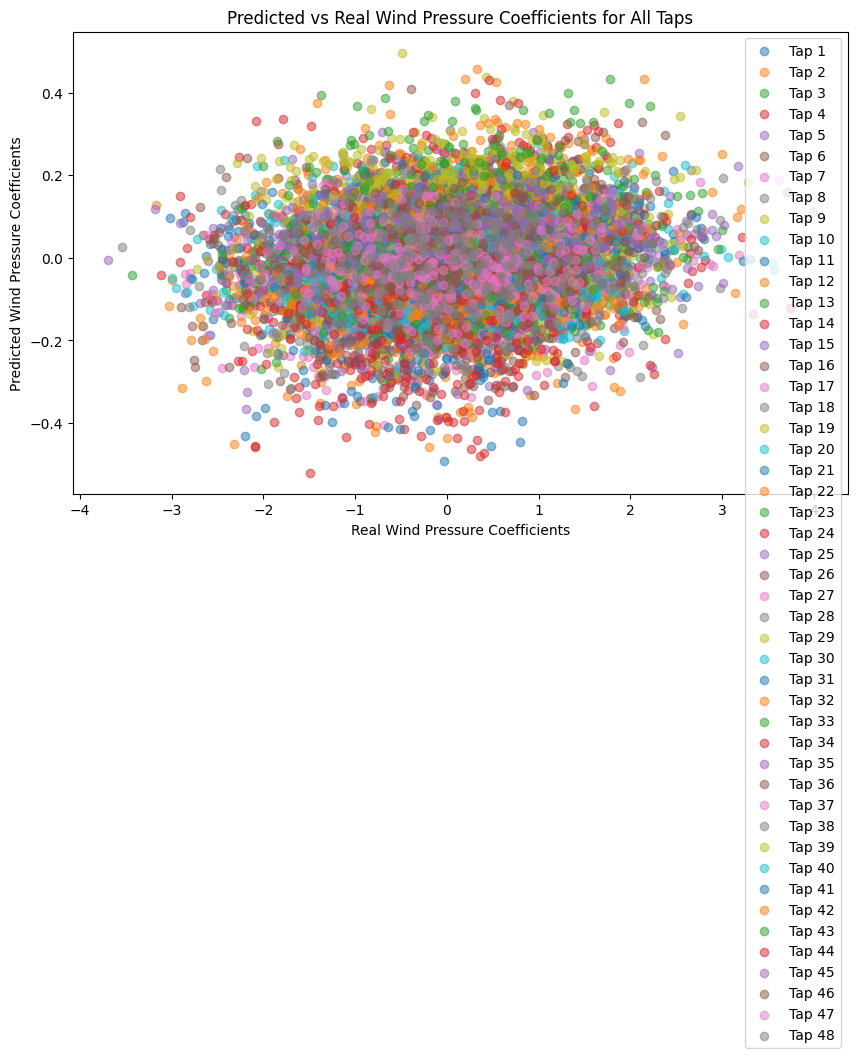

Enter values for prediction:
Predicted Wind Pressure Coefficients for all taps:
[[ 0.05405147 -0.06215953  0.04526038 -0.01239052 -0.07998929  0.0329752
  -0.05622426  0.12212936  0.01665539  0.23305258  0.01624737 -0.07219536
   0.1245894   0.06482967 -0.09879984 -0.10229927 -0.15926312  0.01470859
  -0.08198107  0.03042464 -0.05854781  0.03423333 -0.12157783 -0.03902324
   0.06570399  0.10550659 -0.08819877 -0.03256987  0.06568912  0.0861323
   0.07971959  0.22276199 -0.14724861 -0.33708823 -0.15208203  0.02310591
  -0.05566228 -0.05624122  0.00243023  0.00973776  0.07056497 -0.1806349
   0.16509046 -0.01325945  0.116967    0.14250523 -0.1260191   0.08766081]]


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Load data (assuming preprocessed data is available)
X_train = torch.randn(256, 3)  # Sample input features
y_train = torch.randn(256, 48)  # Sample output values for all pressure taps

# Define PINN model
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Define loss functions
def continuity_loss(velocity_field):
    return torch.mean(torch.abs(torch.sum(velocity_field, dim=1)))

def momentum_loss(velocity_field, pressure_field, density=1.225, viscosity=1.81e-5):
    grad_pressure = torch.autograd.grad(pressure_field, velocity_field, grad_outputs=torch.ones_like(pressure_field), create_graph=True)[0]
    return torch.mean(torch.abs(density * torch.sum(velocity_field, dim=1) + grad_pressure[:, 0] - viscosity * torch.sum(velocity_field ** 2, dim=1)))

def boundary_condition_loss(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

def total_loss(data_loss, cont_loss, mom_loss, bound_loss):
    return data_loss + 0.1 * cont_loss + 0.1 * mom_loss + 0.1 * bound_loss

# Training settings
input_dim = 3
hidden_dim = 50
output_dim = 48  # Predicting all pressure taps
learning_rate = 0.001
num_epochs = 100
batch_size = 32

model = PINN(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Training loop
loss_history = []
for epoch in range(num_epochs):
    for batch_x, batch_y in data_loader:
        batch_x.requires_grad = True  # Ensure gradients can be computed
        y_pred = model(batch_x)
        data_loss = criterion(y_pred, batch_y)
        cont_loss = continuity_loss(y_pred)
        mom_loss = momentum_loss(batch_x, y_pred)
        bound_loss = boundary_condition_loss(y_pred, batch_y)
        loss = total_loss(data_loss, cont_loss, mom_loss, bound_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# Plot loss history
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Predict on all 256 points
y_pred_all = model(X_train).detach().numpy()

# Plot predicted vs real values for all pressure taps
plt.figure(figsize=(10, 6))
for i in range(output_dim):
    plt.scatter(y_train[:, i], y_pred_all[:, i], alpha=0.5, label=f'Tap {i+1}')
plt.xlabel('Real Wind Pressure Coefficients')
plt.ylabel('Predicted Wind Pressure Coefficients')
plt.title('Predicted vs Real Wind Pressure Coefficients for All Taps')
plt.legend()
plt.show()

# User interaction: Predicting new values
def predict_new_values():
    print("Enter values for prediction:")
    wind_azimuth = float(input("Wind Azimuth: "))
    roof_type = float(input("Roof Type: "))
    height_ratio = float(input("Height Ratio: "))
    input_tensor = torch.tensor([[wind_azimuth, roof_type, height_ratio]], dtype=torch.float32)
    prediction = model(input_tensor).detach().numpy()
    print("Predicted Wind Pressure Coefficients for all taps:")
    print(prediction)

predict_new_values()